INFO:root:Starting the program
INFO:root:Total unique answers: 3131
INFO:root:Initialized dataset with 60000 questions.
INFO:root:Initialized dataset with 30000 questions.
INFO:root:Using device: cuda
INFO:root:All layers up to layer 3 are frozen.
INFO:root:Classifier modified to output 3131 labels
Training Epoch 1: 100%|██████████| 3750/3750 [34:12<00:00,  1.83it/s]
INFO:root:Epoch 1, Loss: 4.5710, Accuracy: 0.3713
Evaluating: 100%|██████████| 1875/1875 [11:21<00:00,  2.75it/s]
INFO:root:Predictions saved to predictions\predictions_epoch_1.csv
INFO:root:Validation Loss: 3.4252, Accuracy: 0.4985
INFO:root:Model saved to models\model_epoch_1_val_loss_3.4252.pth
Training Epoch 2: 100%|██████████| 3750/3750 [34:08<00:00,  1.83it/s]
INFO:root:Epoch 2, Loss: 3.3943, Accuracy: 0.5165
Evaluating: 100%|██████████| 1875/1875 [11:10<00:00,  2.80it/s]
INFO:root:Predictions saved to predictions\predictions_epoch_2.csv
INFO:root:Validation Loss: 3.1178, Accuracy: 0.5554
INFO:root:Model saved to mod

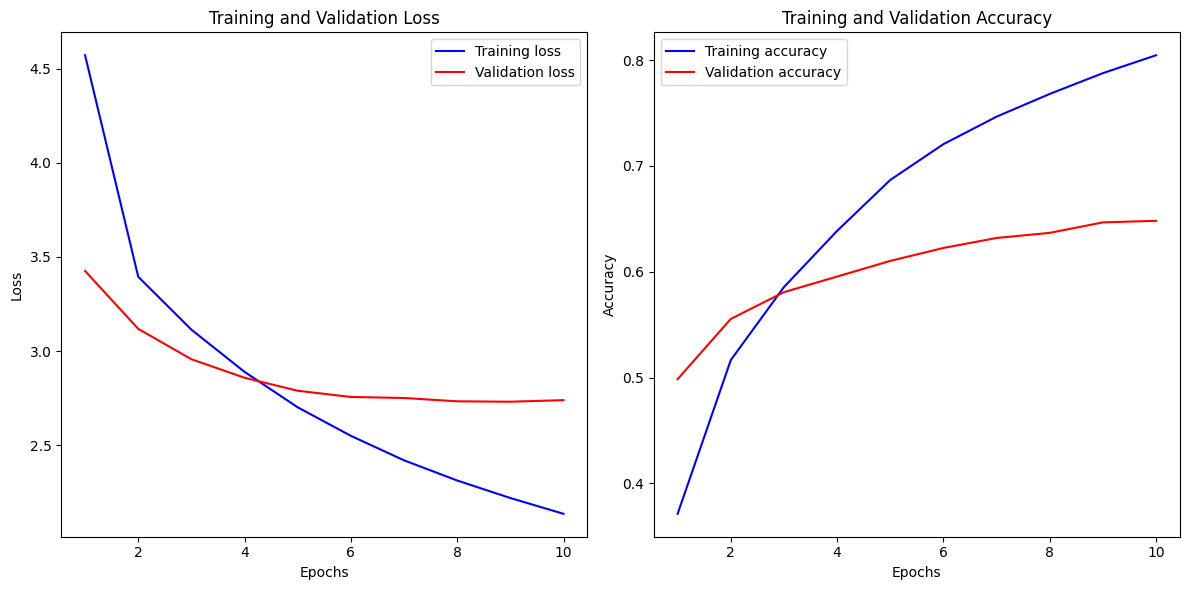

INFO:root:Program completed


In [6]:
import logging
import os
import json
import re  # For regular expressions
from typing import List, Dict, Optional
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViltProcessor, ViltForQuestionAnswering
from tqdm import tqdm
import csv  # For CSV operations
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR


# Setup logging
logging.basicConfig(level=logging.INFO)

# Dataset class
class VQADataset(Dataset):
    def __init__(self, questions_file, annotations_file, image_dir, processor, ans2label):
        self.questions = json.load(open(questions_file))['questions']
        self.image_dir = image_dir
        self.processor = processor
        self.ans2label = ans2label

        # Load annotations
        if annotations_file:
            annotations = json.load(open(annotations_file))['annotations']
            self.annotations = {ann['question_id']: ann for ann in annotations}
        else:
            self.annotations = {}

        logging.info(f"Initialized dataset with {len(self.questions)} questions.")

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        image_id = question['image_id']
        question_id = question['question_id']
        question_text = question['question']

        # Get image path
        image_path = self.get_image_path(image_id)
        if not image_path or not os.path.exists(image_path):
            logging.warning(f"Image not found for image_id {image_id}")
            return None  # Skip if image is not found

        image = Image.open(image_path).convert('RGB')

        # Process inputs
        encoding = self.processor(images=image, text=question_text, return_tensors="pt", padding="max_length", truncation=True)
        item = {
            'pixel_values': encoding['pixel_values'].squeeze(),
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'question_id': question_id,
        }

        # Get label if available
        if question_id in self.annotations:
            answer = self.annotations[question_id]['multiple_choice_answer']
            if answer in self.ans2label:
                label = self.ans2label[answer]
                item['label'] = label
                item['answer'] = answer  # Store the ground truth answer
            else:
                return None  # Skip if answer not in label mapping
        else:
            return None  # Skip if no annotation available

        return item

    def get_image_path(self, image_id):
        # Using the function you provided
        pattern = str(int(image_id))
        for filename in os.listdir(self.image_dir):
            if re.search(pattern, filename):
                return os.path.join(self.image_dir, filename)
        return None  # Image not found

# Collate function for DataLoader
def vqa_collate_fn(batch):
    # Remove None items
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None  # Return None if batch is empty
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    question_ids = [item['question_id'] for item in batch]
    answers = [item['answer'] for item in batch]
    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'question_ids': question_ids,
        'answers': answers,
    }

# Function to build answer space
def build_answer_space(annotations_files):
    answers = set()
    for annotations_file in annotations_files:
        annotations = json.load(open(annotations_file))['annotations']
        for ann in annotations:
            answers.add(ann['multiple_choice_answer'])
    answer_space = sorted(list(answers))
    ans2label = {ans: idx for idx, ans in enumerate(answer_space)}
    label2ans = {idx: ans for ans, idx in ans2label.items()}
    return answer_space, ans2label, label2ans

# VQA Model class
class VQAModel:
    def __init__(self, model_name="dandelin/vilt-b32-finetuned-vqa", num_labels: Optional[int] = None,
                 freeze_layers: bool = False, freeze_up_to_layer: Optional[int] = None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logging.info(f"Using device: {self.device}")

        self.processor = ViltProcessor.from_pretrained(model_name)
        self.model = ViltForQuestionAnswering.from_pretrained(model_name).to(self.device)

        # Freeze layers if specified
        if freeze_layers and freeze_up_to_layer is not None:
            self.freeze_layers(freeze_up_to_layer)

        if num_labels is not None:
            # Modify the classifier to match num_labels
            # Check if classifier is a Sequential module
            if isinstance(self.model.classifier, torch.nn.Sequential):
                # Find the first Linear layer to get in_features
                in_features = None
                for layer in self.model.classifier:
                    if isinstance(layer, torch.nn.Linear):
                        in_features = layer.in_features
                        break
                if in_features is None:
                    raise ValueError("No Linear layer found in the classifier.")
            else:
                in_features = self.model.classifier.in_features

            # Replace the classifier with a new Linear layer
            if num_labels is not None:
                self.model.classifier = torch.nn.Sequential(
                    torch.nn.Linear(in_features, 1024),
                    torch.nn.BatchNorm1d(1024),
                    torch.nn.LeakyReLU(negative_slope=0.01),
                    torch.nn.Dropout(p=0.5),
                    torch.nn.Linear(1024, 512),
                    torch.nn.BatchNorm1d(512),
                    torch.nn.LeakyReLU(negative_slope=0.01),
                    torch.nn.Dropout(p=0.5),
                    torch.nn.Linear(512, num_labels)
                ).to(self.device)
                logging.info(f"Classifier modified to output {num_labels} labels")
    
    def extract_layer_num(self, layer_name: str) -> Optional[int]:
        match = re.search(r'layer\.(\d+)', layer_name)
        if match:
            return int(match.group(1))
        return None

    def freeze_layers(self, freeze_up_to_layer: int):
        for name, param in self.model.named_parameters():
            layer_num = self.extract_layer_num(name)
            if layer_num is not None and layer_num < freeze_up_to_layer:
                param.requires_grad = False
                logging.debug(f"Frozen layer: {name}")
        logging.info(f"All layers up to layer {freeze_up_to_layer - 1} are frozen.")

    def train(self, train_loader, val_loader, epochs=10, lr=1e-5):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        scaler = torch.amp.GradScaler()

        # Early stopping parameters
        best_val_loss = float('inf')
        best_val_acc = 0
        patience = 2  # Adjust as needed
        trigger_times = 0

        # Lists to store metrics for visualization
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0

            # Reset variables at the start of each epoch
            torch.cuda.empty_cache()  # Clear GPU cache

            for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
                if batch is None:
                    continue  # Skip empty batches
                optimizer.zero_grad()
                inputs = {k: v.to(self.device, non_blocking=True) for k, v in batch.items() if k not in ['labels', 'question_ids', 'answers']}
                labels = batch['labels'].to(self.device, non_blocking=True)
                
                with torch.amp.autocast(device_type=self.device.type):
                    outputs = self.model(**inputs)
                    logits = outputs.logits
                    loss = loss_fn(logits, labels)
                    
                scaler.scale(loss).backward()
                
                # Clip gradients
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
                

                total_loss += loss.item()
                preds = logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                # Optionally clear cache after each batch
                # torch.cuda.empty_cache()

            avg_loss = total_loss / len(train_loader)
            accuracy = correct / total if total > 0 else 0
            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)
            logging.info(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

            # Validation
            val_loss, val_accuracy = self.evaluate(val_loader, save_predictions=True, epoch=epoch+1)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            logging.info(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
            
            scheduler.step(val_loss)
            
            # Early stopping logic
            if val_loss < best_val_loss and val_accuracy > best_val_acc:
                best_val_loss = val_loss
                best_val_acc = val_accuracy
                trigger_times = 0
                # Save the model checkpoint
                model_filename = f"model_epoch_{epoch+1}_val_loss_{val_loss:.4f}.pth"
                model_path = os.path.join('models', model_filename)
                torch.save(self.model.state_dict(), model_path)
                logging.info(f"Model saved to {model_path}")
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    logging.info('Early stopping triggered!')
                    break

            # Clear GPU cache after validation
            torch.cuda.empty_cache()

        # Clear GPU cache after training
        torch.cuda.empty_cache()
        
        # Plotting the metrics

        plt.figure(figsize=(12, 6))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(train_losses) + 1), train_losses, 'b', label='Training loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b', label='Training accuracy')
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'r', label='Validation accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Save the plot as a PNG file  
        plt.savefig('C:/Users/mrtur/OneDrive/Desktop/MMAI/MMAI_894/Project/training_validation_metrics.png')
        plt.tight_layout()
        plt.show()

    def evaluate(self, data_loader, save_predictions=False, epoch=None):
        self.model.eval()
        loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_question_ids = []
        all_gt_answers = []
        all_pred_answers = []

        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Evaluating"):
                if batch is None:
                    continue  # Skip empty batches
                inputs = {k: v.to(self.device, non_blocking=True) for k, v in batch.items() if k not in ['labels', 'question_ids', 'answers']}
                labels = batch['labels'].to(self.device, non_blocking=True)
                
                with torch.amp.autocast(device_type=self.device.type):  
                    outputs = self.model(**inputs)
                    logits = outputs.logits
                    loss = loss_fn(logits, labels)

                total_loss += loss.item()
                preds = logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                if save_predictions:
                    # Collect data for saving
                    all_preds.extend(preds.cpu().tolist())
                    all_question_ids.extend(batch['question_ids'])
                    all_gt_answers.extend(batch['answers'])
                    pred_answers = [label2ans[pred] for pred in preds.cpu().tolist()]
                    all_pred_answers.extend(pred_answers)

        avg_loss = total_loss / len(data_loader)
        accuracy = correct / total if total > 0 else 0

        if save_predictions and total > 0:
            # Save predictions to CSV
            output_dir = "predictions"
            os.makedirs(output_dir, exist_ok=True)
            csv_filename = f"predictions_epoch_{epoch}.csv" if epoch else "predictions.csv"
            csv_path = os.path.join(output_dir, csv_filename)
            with open(csv_path, mode='w', newline='', encoding='utf-8') as csvfile:
                fieldnames = ['question_id', 'ground_truth_answer', 'predicted_answer']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for q_id, gt_ans, pred_ans in zip(all_question_ids, all_gt_answers, all_pred_answers):
                    writer.writerow({
                        'question_id': q_id,
                        'ground_truth_answer': gt_ans,
                        'predicted_answer': pred_ans
                    })
            logging.info(f"Predictions saved to {csv_path}")

        # Clear GPU cache after evaluation
        torch.cuda.empty_cache()

        # Reset lists to free memory
        all_preds.clear()
        all_question_ids.clear()
        all_gt_answers.clear()
        all_pred_answers.clear()

        return avg_loss, accuracy

# Main function
def main():
    logging.info("Starting the program")

    # Set up paths
    base_path = "C:/Users/mrtur/OneDrive/Desktop/MMAI/MMAI_894/Project/"
    train_questions_file = os.path.join(base_path, "Questions_Train_abstract_v002", "MultipleChoice_abstract_v002_train2015_questions.json")
    train_annotations_file = os.path.join(base_path, "Annotations_Train_abstract_v002", "abstract_v002_train2015_annotations.json")
    train_image_dir = os.path.join(base_path, "scene_img_abstract_v002_train2015")

    val_questions_file = os.path.join(base_path, "Questions_Val_abstract_v002", "MultipleChoice_abstract_v002_val2015_questions.json")
    val_annotations_file = os.path.join(base_path, "Annotations_Val_abstract_v002", "abstract_v002_val2015_annotations.json")
    val_image_dir = os.path.join(base_path, "scene_img_abstract_v002_val2015")

    # Build global answer space
    global label2ans  # Make label2ans accessible globally
    answer_space, ans2label, label2ans = build_answer_space([train_annotations_file, val_annotations_file])
    num_labels = len(answer_space)
    logging.info(f"Total unique answers: {num_labels}")

    # Initialize processor
    processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

    # Create datasets
    train_dataset = VQADataset(train_questions_file, train_annotations_file, train_image_dir, processor, ans2label)
    val_dataset = VQADataset(val_questions_file, val_annotations_file, val_image_dir, processor, ans2label)

    # Create data loaders
    batch_size = 16  # Adjust based on your GPU memory
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=vqa_collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=vqa_collate_fn, pin_memory=True)

    # Initialize model
    freeze_up_to_layer = 4
    model = VQAModel(num_labels=num_labels, freeze_layers=True, freeze_up_to_layer=freeze_up_to_layer)

    # Train and validate
    model.train(train_loader, val_loader, epochs=10)

    logging.info("Program completed")

if __name__ == "__main__":
    main()
